# Validation


## Imports / Setup


In [25]:
import boto3
import pandas as pd
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
from ladybug.epw import EPW
from lightning.pytorch import Trainer
import torch
import numpy as np

from ml.surrogate import Surrogate
from ml.predict import predict_ubem
from utils.constants import JOULES_TO_KWH
from weather.weather import extract

from archetypal import settings

if os.name == "nt":
    settings.ep_version == "22.2.0"
    settings.energyplus_location = Path("C:/EnergyPlusV22-2-0")
else:
    settings.ep_version == "22.2.0"
    settings.energyplus_location = Path("/usr/local/EnergyPlus-22-2-0")

from archetypal.idfclass import IDF

## Config Vars


In [26]:
bucket = "ml-for-bem"
s3 = boto3.client("s3")

local_dir = Path("data") / "temp"
experiment_type = "validation"
version = "v5"
city = "fairbanks"
experiment_name = f"{experiment_type}/{version}/{city}"
should_gather_idf = False

registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v3"
resource = "model.ckpt"

## Helper Fns


In [27]:
# list objects in bucket using paginator
def get_files_in_experiment(experiment):
    print("Listing files for experiment: ", experiment, "...")
    files = []
    paginator = s3.get_paginator("list_objects_v2")
    for page in paginator.paginate(Bucket=bucket, Prefix=experiment):
        if page.get("Contents"):
            for obj in page["Contents"]:
                files.append(obj["Key"])
    return files


def download(file):
    filepath = local_dir / file
    os.makedirs(filepath.parent, exist_ok=True)
    s3.download_file(bucket, file, filepath)
    return filepath


def download_and_open_json(file):
    filepath = download(file)
    with open(filepath, "r") as f:
        return json.load(f)


def download_and_open_hdf(file):
    filepath = download(file)
    return pd.read_hdf(filepath)


def get_weather():
    weather_folder = (Path(experiment_name).parent / "epw").as_posix()
    # list files in weather folder
    weather_files = get_files_in_experiment(weather_folder)
    with ThreadPoolExecutor(max_workers=8) as executor:
        weather_files = list(
            tqdm(executor.map(download, weather_files), total=len(weather_files))
        )
    return weather_files


def download_and_open_ground_truth():
    file = experiment_name + "/Buildings.hdf"
    true_df = download_and_open_hdf(file)

    true_df = true_df.sort_index(level="file_name")
    building_id = (
        true_df.index.to_frame()["file_name"].str.split(".").str[0].astype(int)
    )
    building_id.name = "building_id"
    true_df = true_df.set_index(building_id, append=True).sort_index(
        level="building_id"
    )

    true_df = true_df * JOULES_TO_KWH
    return true_df

## Load Surrogate


In [28]:
surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
surrogate.model.eval()
torch.set_float32_matmul_precision("medium")

trainer = Trainer(
    accelerator="auto",
    devices="auto",
    strategy="auto",
    enable_progress_bar=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Gather/Download Validation Files


In [29]:
if should_gather_idf:
    idf_files = get_files_in_experiment(experiment_name + "/idf")
    idf_files = idf_files[:100]
    with ThreadPoolExecutor(max_workers=8) as executor:
        idf_files = list(tqdm(executor.map(download, idf_files), total=len(idf_files)))

features_fp = Path(experiment_name).parent / "features.hdf"
features_fp = download(features_fp.as_posix())
features = pd.read_hdf(features_fp, key="shoeboxes")
building_features = pd.read_hdf(features_fp, key="buildings")

## Check for errors in hdf etc


In [30]:
check = False


def test_idf(building_id):
    idf_path = (
        Path("data")
        / "temp"
        / Path(experiment_name).parent
        / "idf"
        / f"{building_id:09d}.idf"
    ).as_posix()

    idf = IDF(idf_path)

    zones = idf.idfobjects["ZONE"]

    # remove final _<number> from zone names

    zone_names = ["_".join(zone.Name.split("_")[:-1]) for zone in zones]

    zones_by_name = {zone_name: zone for zone_name, zone in zip(zone_names, zones)}

    area = 0

    i = 0

    for zone in zones_by_name.values():
        area += zone.Floor_Area

        i += 1

    assert abs(building_features.loc[building_id, "gfa"] - area) < 1
    areas = (
        features.groupby(level="building_id")
        .sum()
        .loc[building_id, ["core_area", "zone_perimeter_area"]]
    )

    assert np.abs(areas["core_area"] / 4 + areas["zone_perimeter_area"] - area) < 1e-1


if check:
    for building_id in tqdm(building_features.index.to_list()[:10]):
        test_idf(building_id)

## Allocate Shoebox dimensions

Floor-to-floor height and shoebox width are fixed.


In [31]:
# features.VentilationMode = 2
print("Warning: Setting Ventilation Mode to 2")

width = 3
features.width = width
building_features.width = width
zone_facade_area = features.zone_edge_length * features.height
zone_perim_floor_area_to_facade_area = features.zone_perimeter_area / zone_facade_area
zone_core_area_to_perimeter_area = features.core_area / features.zone_perimeter_area
building_perimeter_area = features.footprint_area - features.core_area
building_core_area_to_perimeter_area = features.core_area / building_perimeter_area
building_facade_area = features.total_perimeter_length * features.height
building_perimeter_area_to_facade_area = building_perimeter_area / building_facade_area
"""
Strategy 1: 
Use the building's core area and perimeter area, and facade area per floor to compute the depth of the core and perimeter
"""
sb_facade_area = features.width * features.height
sb_perim_area = sb_facade_area * building_perimeter_area_to_facade_area
sb_perim_depth = sb_perim_area / features.width
sb_core_depth = sb_perim_depth * building_core_area_to_perimeter_area
features["perim_depth"] = sb_perim_depth
features["core_depth"] = sb_core_depth
features["roof_2_footprint"] = 1 / features.n_floors
features["ground_2_footprint"] = 1 / features.n_floors

"""
Strategy 2: 
use each perimeter zone's perimeter area and core area, and facade area (for that edge) to compute the depth of the core and perimeter
"""

# features.width = 5
# sb_perim_facade_area = features.width * features.height
# sb_perim_area = features.zone_perim_floor_area_to_facade_area * sb_perim_facade_area
# sb_perim_depth = sb_perim_area / features.width
# sb_core_depth = features.zone_core_area_to_perimeter_area * sb_perim_depth
# features["perim_depth"] = sb_perim_depth
# features["core_depth"] = sb_core_depth

"""
Strategy 3:
Use the building's one-floor facade area to the total footprint area to compute the total depth of a shoebox
then compute the depth of the core and perimeter
"""

# features.width = 2
# fp_to_facade_ratio = (
#     features.footprint_area / features.building_facade_area_per_one_floor
# )

# core_frac = features.core_area / features.footprint_area
# sb_depth = features.height * fp_to_facade_ratio  # * 3
# sb_core_depth = sb_depth * core_frac
# sb_perim_depth = sb_depth * (1 - core_frac)
# features["perim_depth"] = sb_perim_depth
# features["core_depth"] = sb_core_depth  # * 2

# features["roof_2_footprint"] = 1 / features.n_floors
# features["ground_2_footprint"] = 1 / features.n_floors


# bcore_frac = building_features.core_area / building_features.footprint_area

# print("shoeboxes allocated")

"\nStrategy 3:\nUse the building's one-floor facade area to the total footprint area to compute the total depth of a shoebox\nthen compute the depth of the core and perimeter\n"

## Load Weather, Schedules


In [32]:
weather_files = get_weather()
epw_path = next(filter(lambda x: city.lower() in str(x).lower(), weather_files))
print(epw_path)
epw = EPW(epw_path)
climate = extract(epw)
scheds = np.load("data/schedules.npy")

Listing files for experiment:  validation/v5/epw ...


  0%|          | 0/13 [00:00<?, ?it/s]

data\temp\validation\v5\epw\USA_AK_Fairbanks.Intl.AP.702610_TMYx.2007-2021.epw


## Load Surrogate and Predict


In [33]:
ml_shoebox_results, ml_monthly, ml_annual = predict_ubem(
    trainer=trainer,
    surrogate=surrogate,
    features=features.reset_index(),
    schedules=scheds,
    climate=climate,
    apply_cops=False,
    batch_size=64,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3440/3440 [01:55<00:00, 29.84it/s]


## Compute Electricity


In [34]:
month_lengths = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
cols = ml_monthly.Heating.columns

pred_elec = pd.DataFrame(columns=cols, index=[])
for ix, row in tqdm(list(building_features.iterrows()), total=len(building_features)):
    template_ix = int(row["template_idx"])
    e_sched = scheds[template_ix, 0]
    l_sched = scheds[template_ix, 1]
    lpd = row["LightingPowerDensity"]  # measured in Watts/m2
    epd = row["EquipmentPowerDensity"]  # measured in Watts/m2
    e_timestep = epd * e_sched / 1000  # kWh / m2
    l_timestep = lpd * l_sched / 1000  # kWh / m2
    total = e_timestep + l_timestep
    # split total into months, each timestep is one hour
    hours_passed = 0
    month_totals = []
    for month in month_lengths:
        month_total = total[hours_passed : hours_passed + month * 24]
        hours_passed += month * 24
        month_totals.append(month_total.sum())
    pred_elec.loc[ix] = month_totals
pred_elec.columns = pd.MultiIndex.from_product([["Electricity"], pred_elec.columns])
# ml_annual["Electricity"] = pred_elec.sum(axis=1)
ml_monthly_with_elec = pd.concat([ml_monthly, pred_elec], axis=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

## Load Ground Truth


In [35]:
true_results = download_and_open_ground_truth()
true_results.drop_duplicates(inplace=True)


true_results_ids = true_results.index.get_level_values("building_id")

if len(true_results) != len(building_features):
    print(
        "WARNING: Not all buildings have ground truth results uncomment the lines below to continue!!"
    )
    features = features.loc[(true_results_ids, slice(None))]
    building_features = building_features.loc[true_results_ids]
    ml_monthly = ml_monthly.loc[true_results_ids]
    ml_annual = ml_annual.loc[true_results_ids]
    pred_elec = pred_elec.loc[true_results_ids]
    ml_monthly_with_elec = ml_monthly_with_elec.loc[true_results_ids]


true_results = true_results / building_features.loc[
    true_results_ids, "gfa"
].values.reshape(-1, 1)

true_results.index = true_results_ids

assert (true_results.index == ml_monthly.index).all()

## Merge and Save


In [36]:
true_results_renamed = true_results.rename(
    columns={
        "Electricity:Facility": "Electricity",
        "Heating:DistrictHeating": "Heating",
        "Cooling:DistrictCooling": "Cooling",
    },
)
true_results_renamed = true_results_renamed[ml_monthly_with_elec.columns]
residuals = true_results_renamed - ml_monthly_with_elec


# merge true and predicted results
all_results = pd.concat(
    [true_results_renamed, ml_monthly_with_elec, residuals],
    axis=1,
    keys=["True", "Predicted", "Residuals"],
)
all_results.to_hdf(local_dir / experiment_type / version / f"{city}.hdf", key="results")
building_features.to_hdf(
    local_dir / experiment_type / version / f"{city}.hdf", key="features"
)
s3.upload_file(
    local_dir / experiment_type / version / f"{city}.hdf",
    bucket,
    f"{experiment_type}/{version}/{city}.hdf",
)

## Plot Electricity Comparison


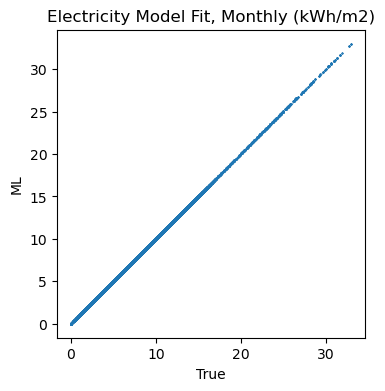

In [37]:
template_indices = (
    building_features.loc[true_results_ids, "template_idx"]
    .astype(float)
    .values.reshape(-1, 1)
    .repeat(12, axis=1)
    .flatten()
)
pred_elec_res = pred_elec.loc[true_results_ids].values.flatten()

fig = plt.figure(figsize=(4, 4))

plt.scatter(
    true_results["Electricity:Facility"].values.flatten(),
    pred_elec_res,
    # alpha=0.1,
    s=0.1,
)
plt.title("Electricity Model Fit, Monthly (kWh/m2)")
plt.xlabel("True")
plt.ylabel("ML")
plt.gca().set_aspect("equal", "box")

## Plotting Energy Loads


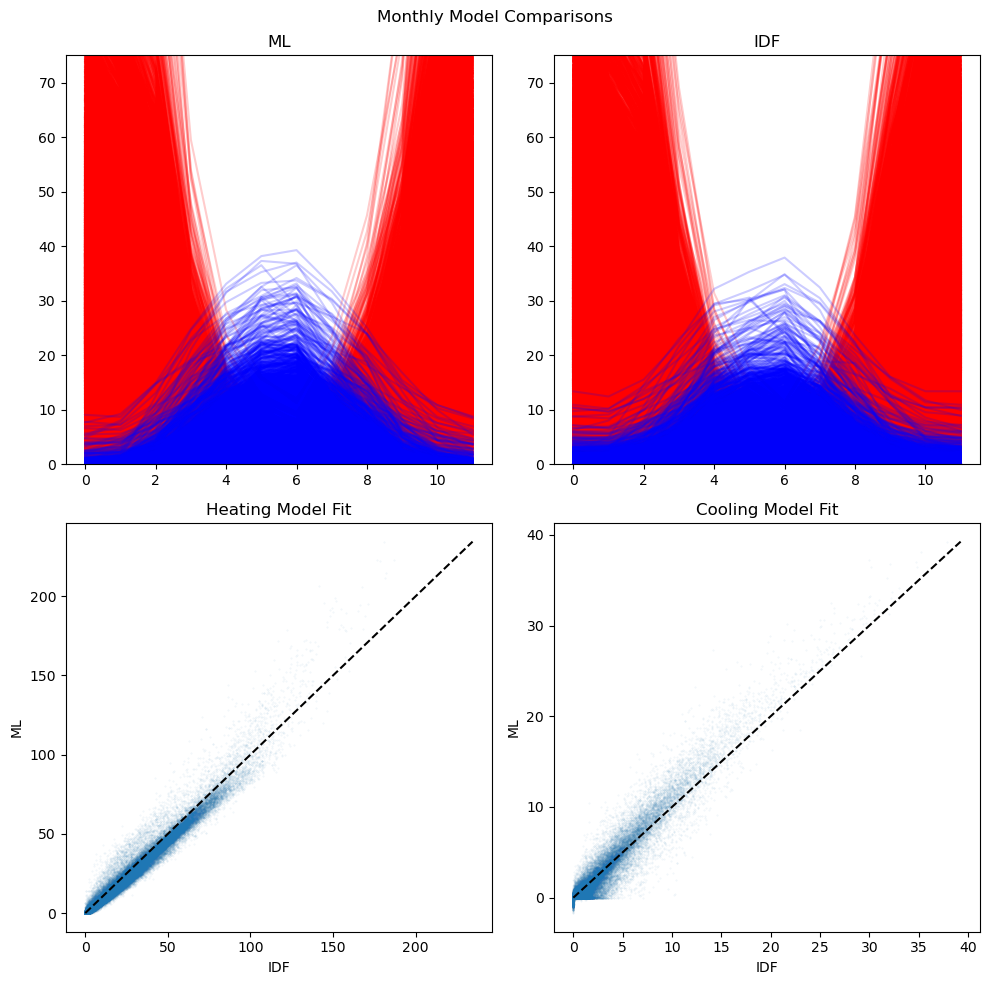

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# ml_monthly = ml_monthly[:1]
# true_results = true_results[:1]
plt.suptitle("Monthly Model Comparisons")


ml_ax = ax[0, 0]
idf_ax = ax[0, 1]
scatter_h_ax = ax[1, 0]
scatter_c_ax = ax[1, 1]


ml_ax.plot(ml_monthly.Heating.values.T, color="red", alpha=0.2)
ml_ax.plot(ml_monthly.Cooling.values.T, color="blue", alpha=0.2)


idf_ax.plot(true_results["Heating:DistrictHeating"].values.T, color="red", alpha=0.2)
idf_ax.plot(true_results["Cooling:DistrictCooling"].values.T, color="blue", alpha=0.2)


ml_ax.set_ylim(0, 75)
idf_ax.set_ylim(0, 75)
ml_ax.set_title("ML")
idf_ax.set_title("IDF")


scatter_h_ax.set_title("Heating Model Fit")
scatter_h_ax.set_xlabel("IDF")
scatter_h_ax.set_ylabel("ML")
scatter_c_ax.set_title("Cooling Model Fit")
scatter_c_ax.set_xlabel("IDF")
scatter_c_ax.set_ylabel("ML")


scatter_h_ax.scatter(
    true_results["Heating:DistrictHeating"].values.flatten(),
    ml_monthly.Heating.values.flatten(),
    # c=bcore_frac.values.reshape(-1, 1).repeat(12, axis=1).flatten(),
    alpha=0.1,
    s=0.1,
)


scatter_c_ax.scatter(
    true_results["Cooling:DistrictCooling"].values.flatten(),
    ml_monthly.Cooling.values.flatten(),
    # c=bcore_frac.values.reshape(-1, 1).repeat(12, axis=1).flatten(),
    alpha=0.1,
    s=0.1,
)


# plot identity line on top of scatter
x = np.linspace(0, np.max(ml_monthly.Cooling.values.flatten()), 100)
scatter_c_ax.plot(x, x, color="black", linestyle="--")
x = np.linspace(0, np.max(ml_monthly.Heating.values.flatten()), 100)
scatter_h_ax.plot(x, x, color="black", linestyle="--")


fig.tight_layout()

## Errors


In [39]:
errs = {}
residuals = {}
for key in ["Heating", "Cooling"]:
    errs_annual = ml_annual[key].values - true_results[
        f"{key}:District{key}"
    ].values.sum(axis=1)
    errs_monthly = ml_monthly[key].values - true_results[f"{key}:District{key}"].values

    errs[key] = {
        "annual": {
            "rmse": np.sqrt(np.mean(errs_annual**2)),
            "mbe": np.mean(errs_annual),
            "mae": np.mean(np.abs(errs_annual)),
            "cvrmse": np.sqrt(np.mean(errs_annual**2))
            / np.mean(true_results[f"{key}:District{key}"].values.sum(axis=1)),
            # "residuals": errs_annual,
        },
        "monthly": {
            "rmse": np.sqrt(np.mean(errs_monthly**2)),
            "mbe": np.mean(errs_monthly),
            "mae": np.mean(np.abs(errs_monthly)),
            "cvrmse": np.sqrt(np.mean(errs_monthly**2))
            / np.mean(true_results[f"{key}:District{key}"].values),
            # "residuals": errs_monthly,
        },
    }
    residuals[key] = {
        "annual": errs_annual,
        "monthly": errs_monthly,
    }
print(json.dumps(errs, indent=4))

{
    "Heating": {
        "annual": {
            "rmse": 33.325129768240515,
            "mbe": -17.4909992593028,
            "mae": 26.3345891994493,
            "cvrmse": 0.1595376539290729
        },
        "monthly": {
            "rmse": 3.88525225698482,
            "mbe": -1.4575832716085666,
            "mae": 2.3594182048202996,
            "cvrmse": 0.22319878157271586
        }
    },
    "Cooling": {
        "annual": {
            "rmse": 5.449638851621292,
            "mbe": -0.3291001543212127,
            "mae": 2.95593075293148,
            "cvrmse": 0.4809392054364805
        },
        "monthly": {
            "rmse": 0.7170953840014358,
            "mbe": -0.02742501286010106,
            "mae": 0.29772819003038153,
            "cvrmse": 0.7594175546540268
        }
    }
}


## Plot Errors


C:\Users\szvsw\AppData\Local\Temp\ipykernel_25960\3869165573.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


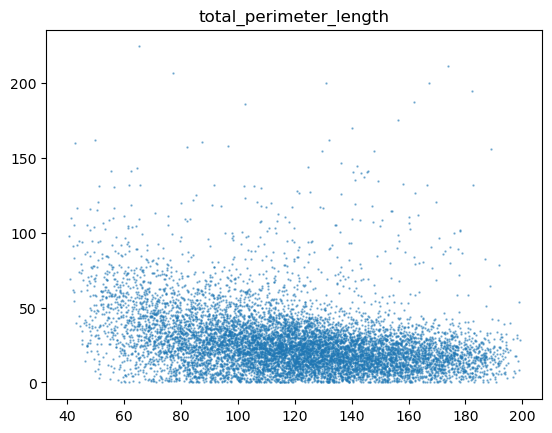

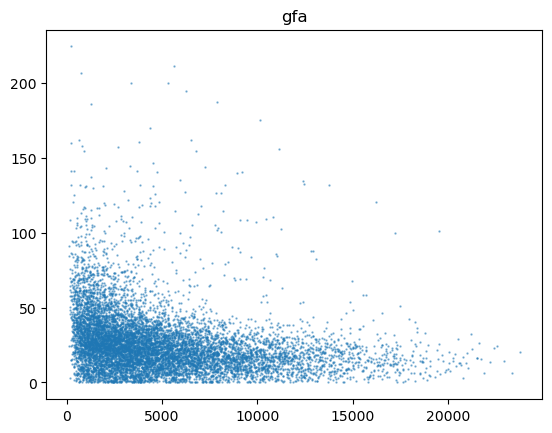

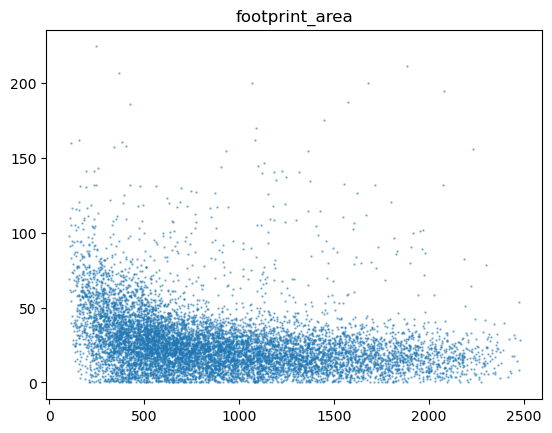

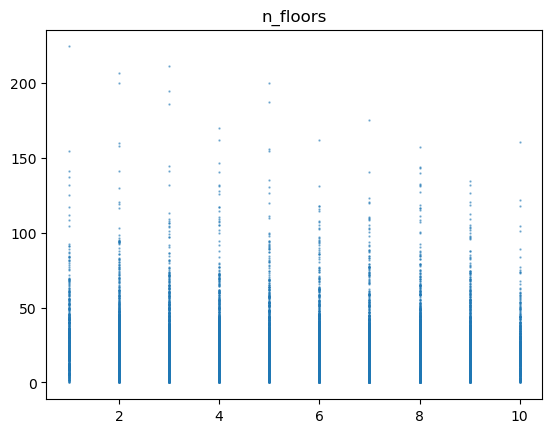

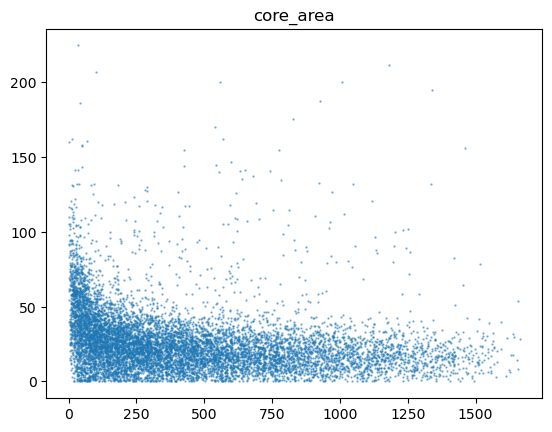

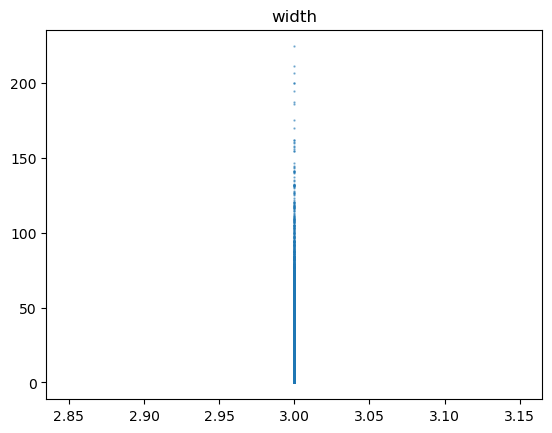

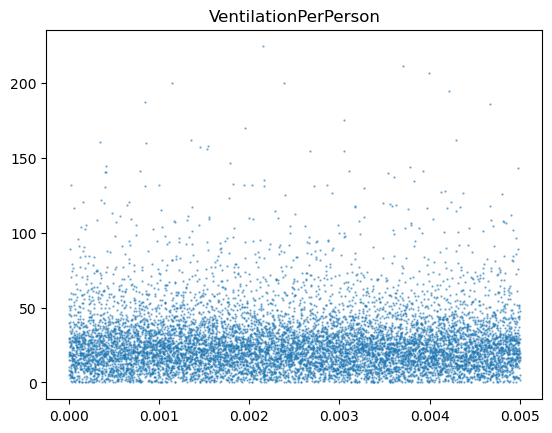

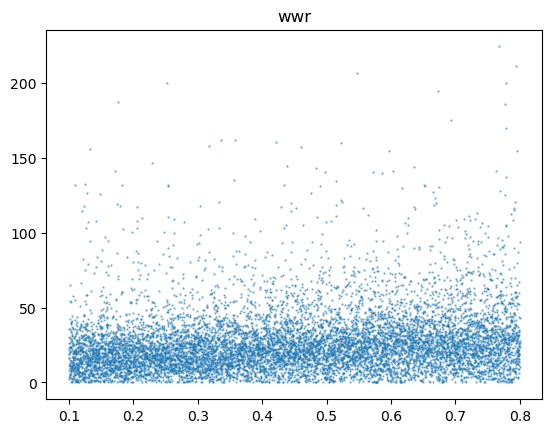

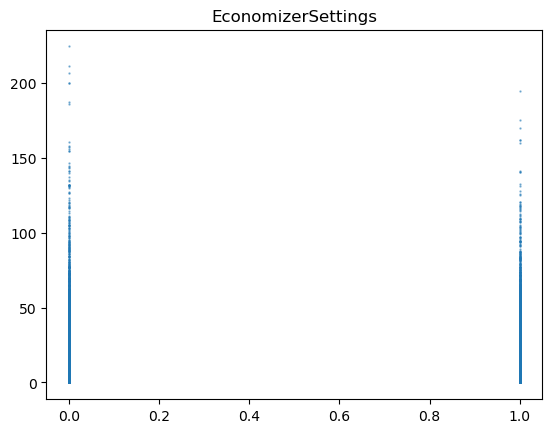

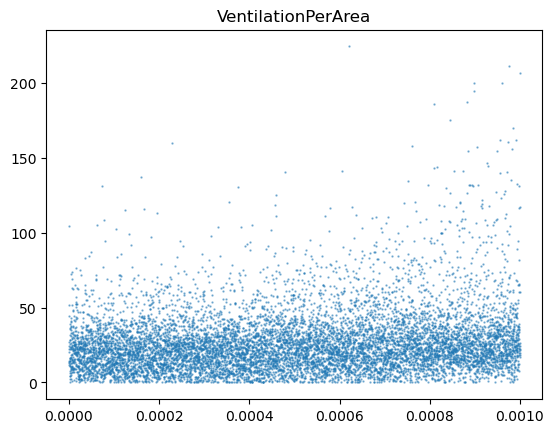

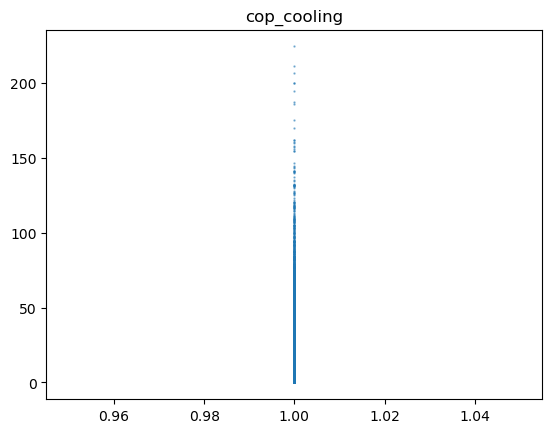

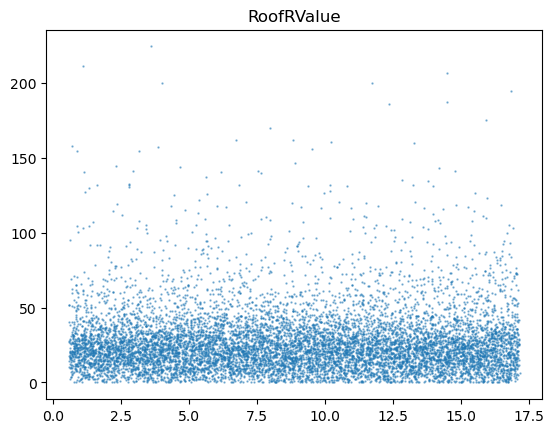

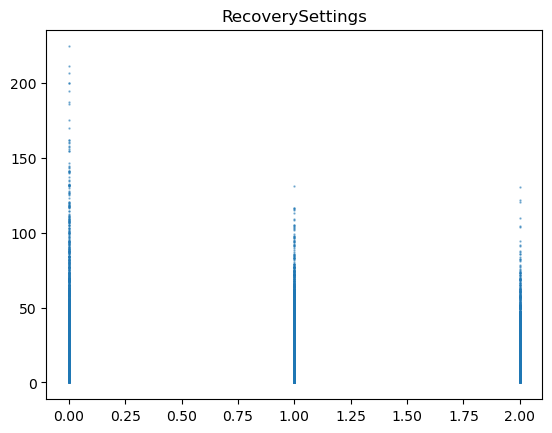

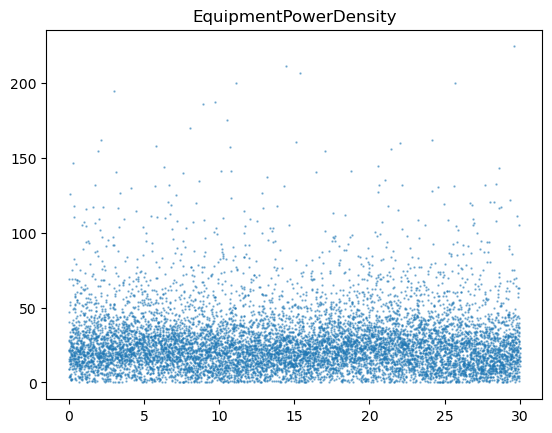

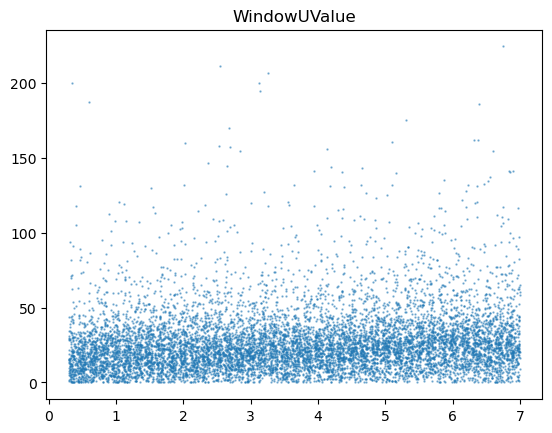

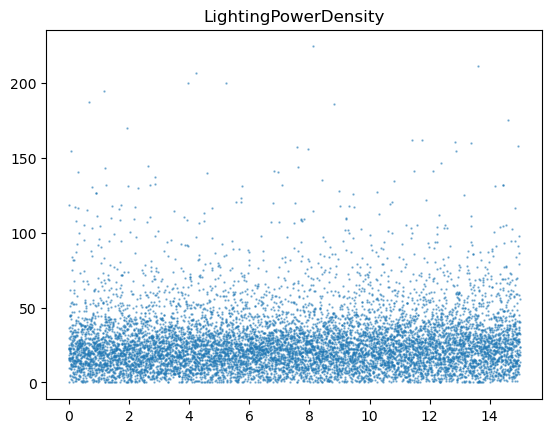

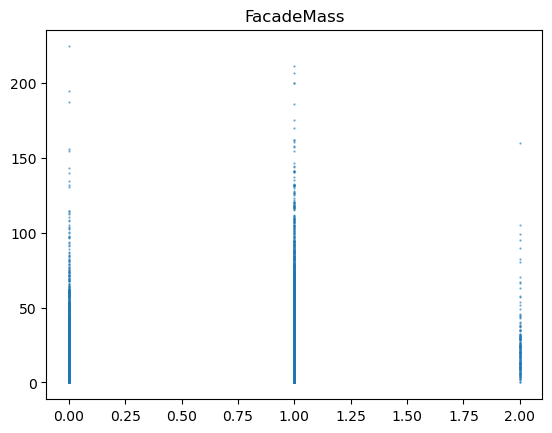

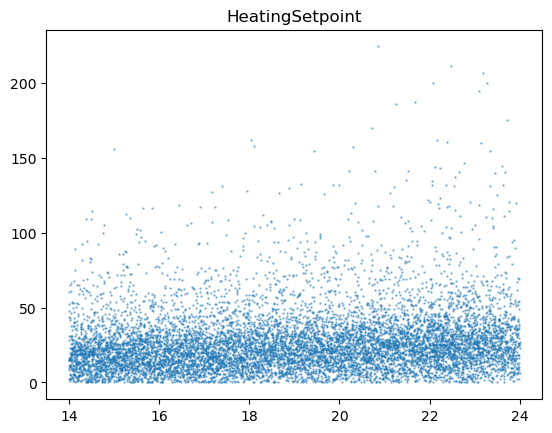

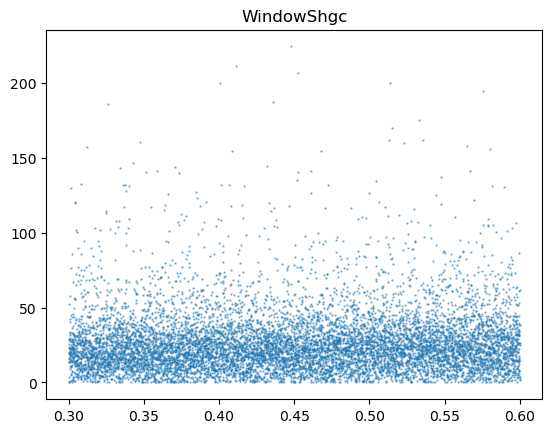

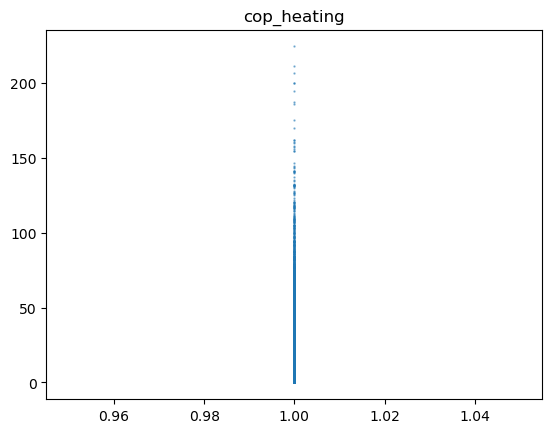

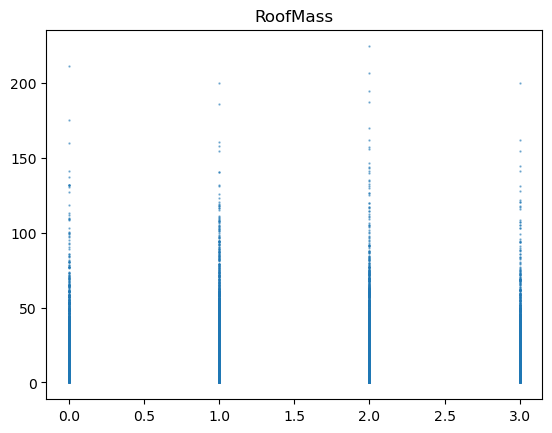

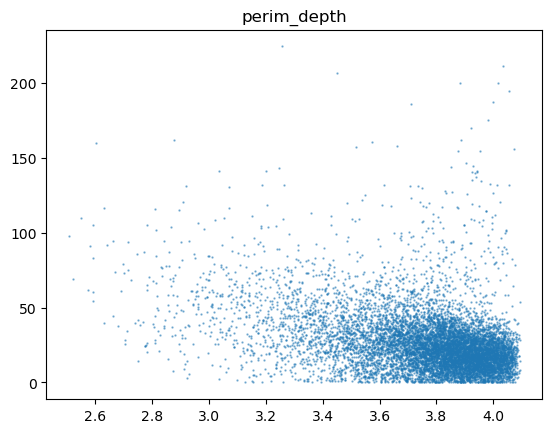

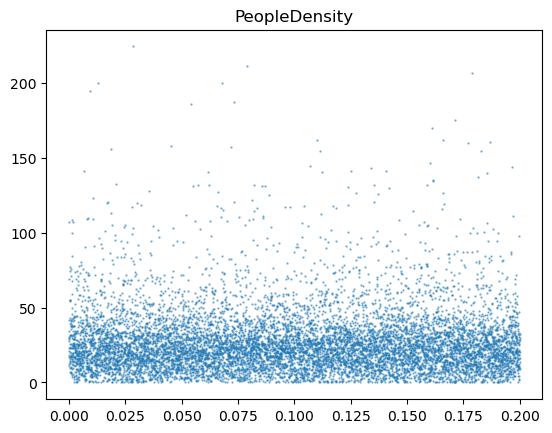

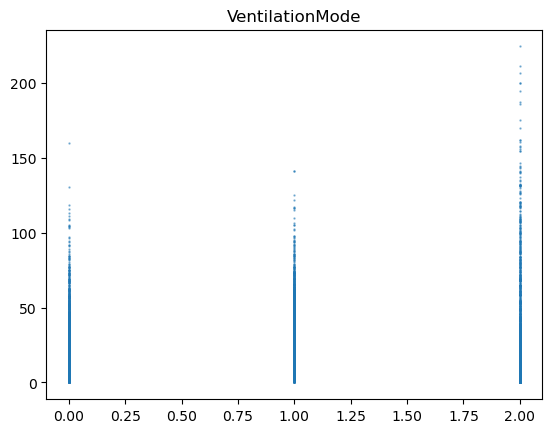

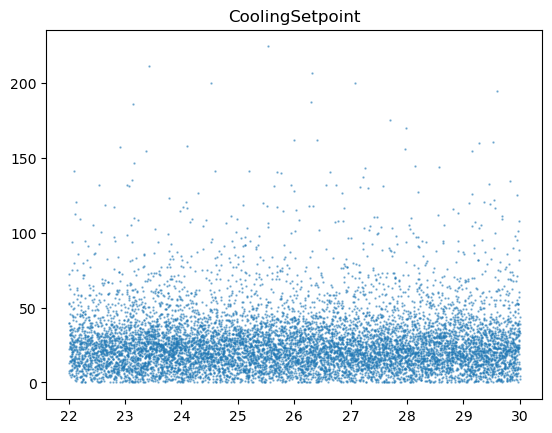

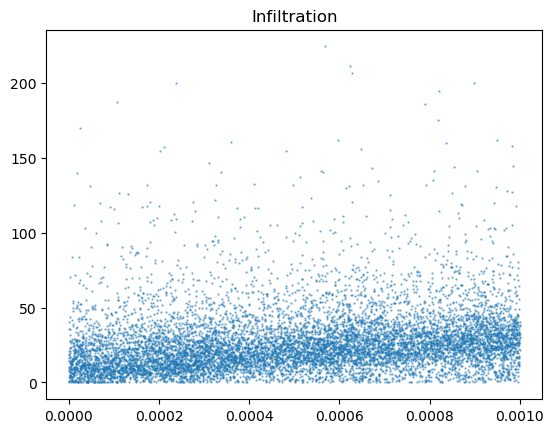

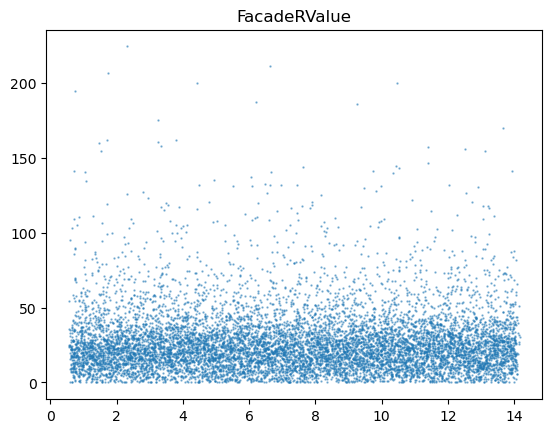

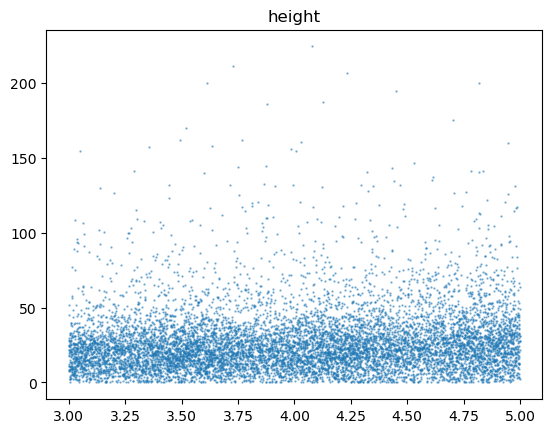

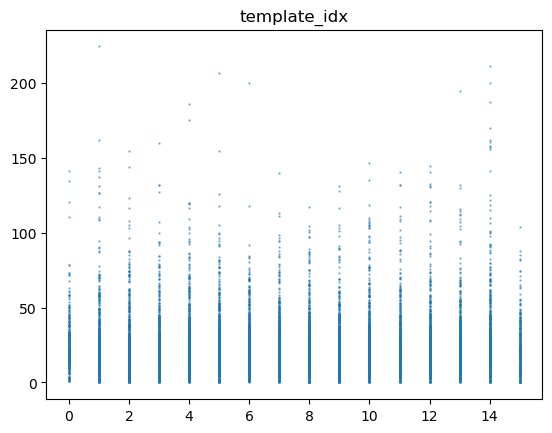

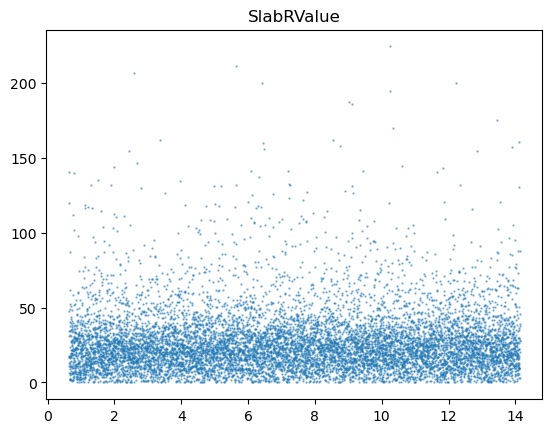

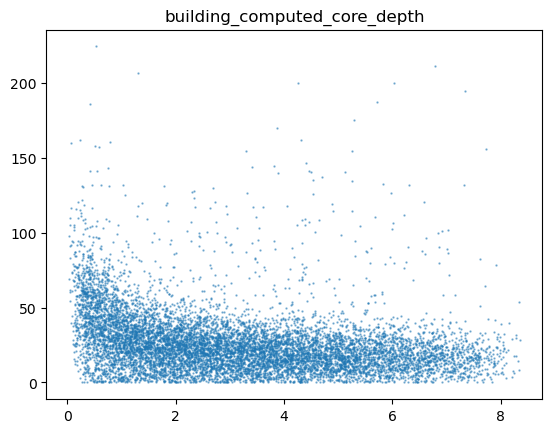

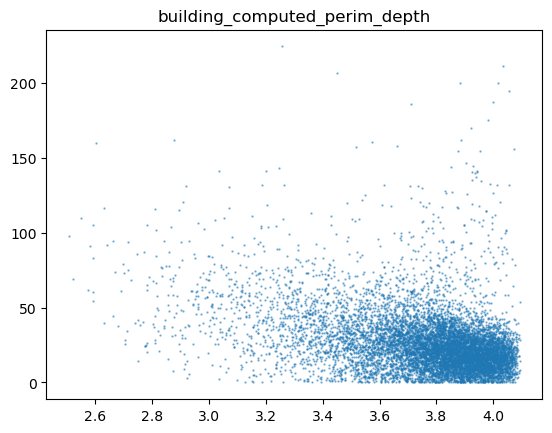

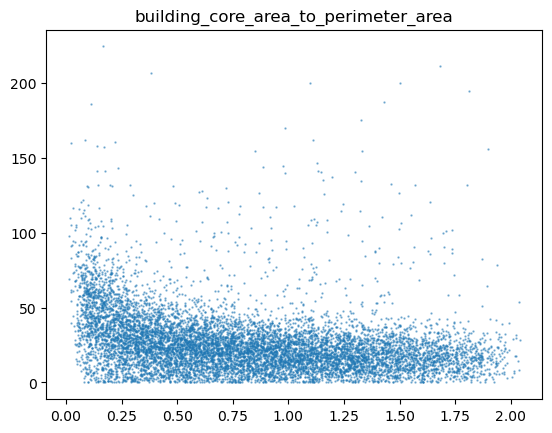

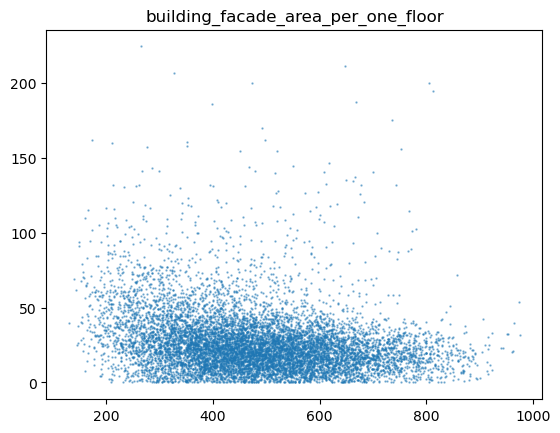

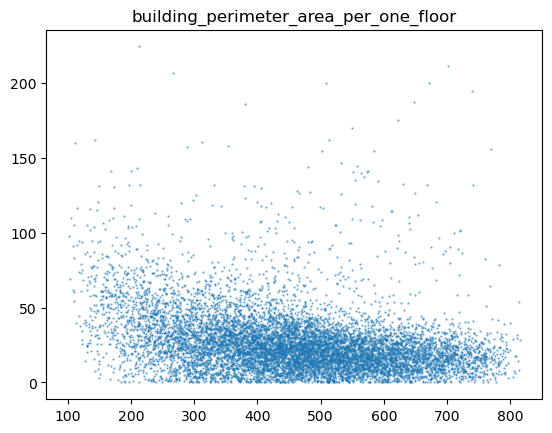

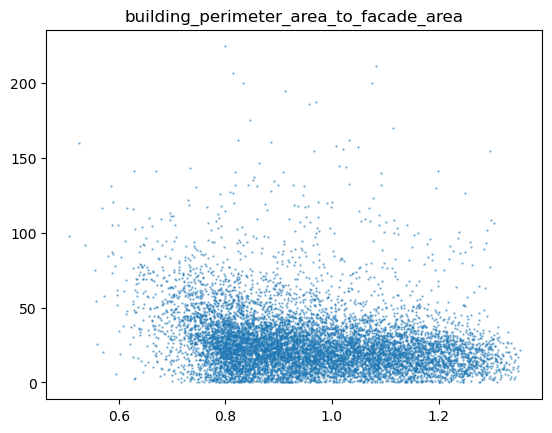

In [40]:
for col in building_features.columns:
    plt.figure()
    try:
        vents = building_features[col].values

        plt.scatter(
            vents,
            np.sqrt(residuals["Heating"]["annual"].flatten() ** 2),
            s=0.5,
            alpha=0.5,
            # color="ered",
        )
    except Exception as e:
        pass
    plt.title(col)

## A/B Comparison


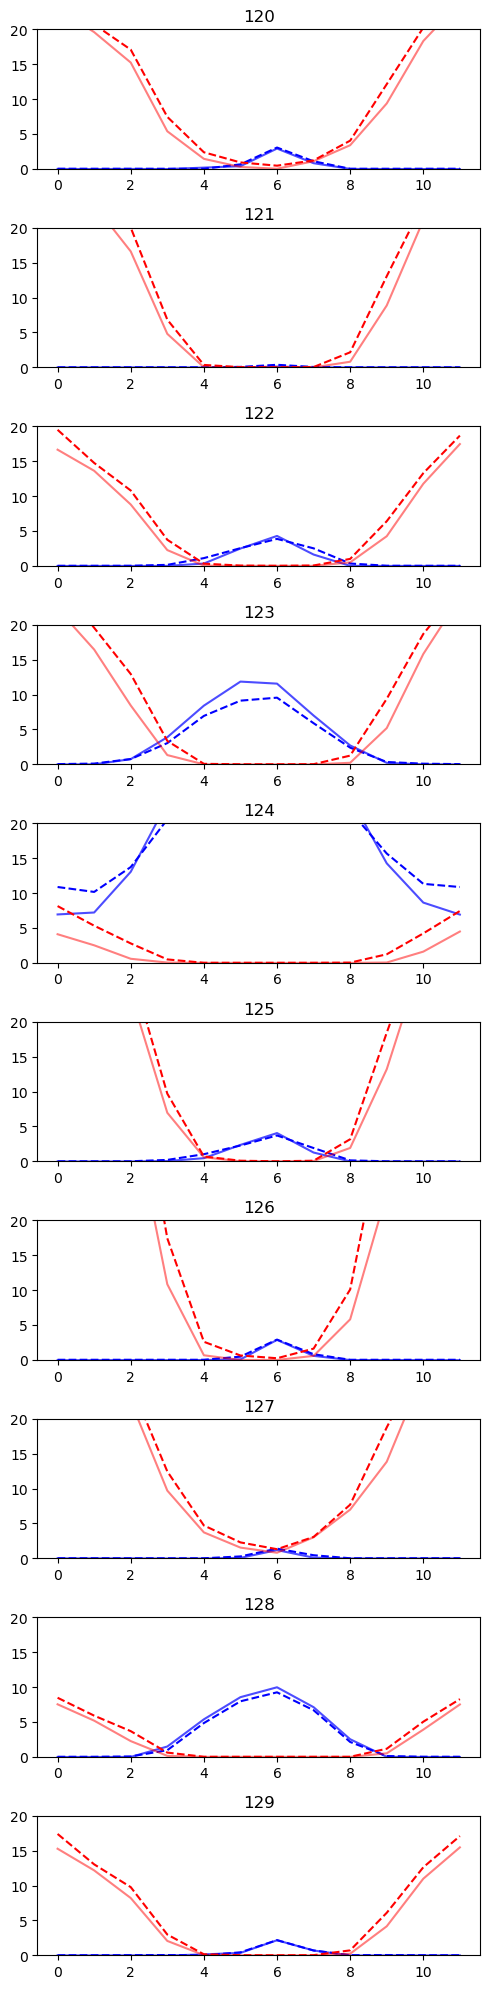

In [41]:
fig, ax = plt.subplots(10, 1, figsize=(5, 20))
for j, i in zip(range(10), range(120, 130)):
    axs = ax[j]
    axs.plot(ml_monthly.iloc[i].Cooling.values, color="blue", alpha=0.7)
    axs.plot(
        true_results.iloc[i]["Cooling:DistrictCooling"].values,
        linestyle="dashed",
        color="blue",
    )
    axs.plot(ml_monthly.iloc[i].Heating.values, color="red", alpha=0.5)
    axs.plot(
        true_results.iloc[i]["Heating:DistrictHeating"].values,
        linestyle="dashed",
        color="red",
    )
    axs.set_ylim(0, 20)
    axs.set_title(i)
fig.tight_layout()

## Annual


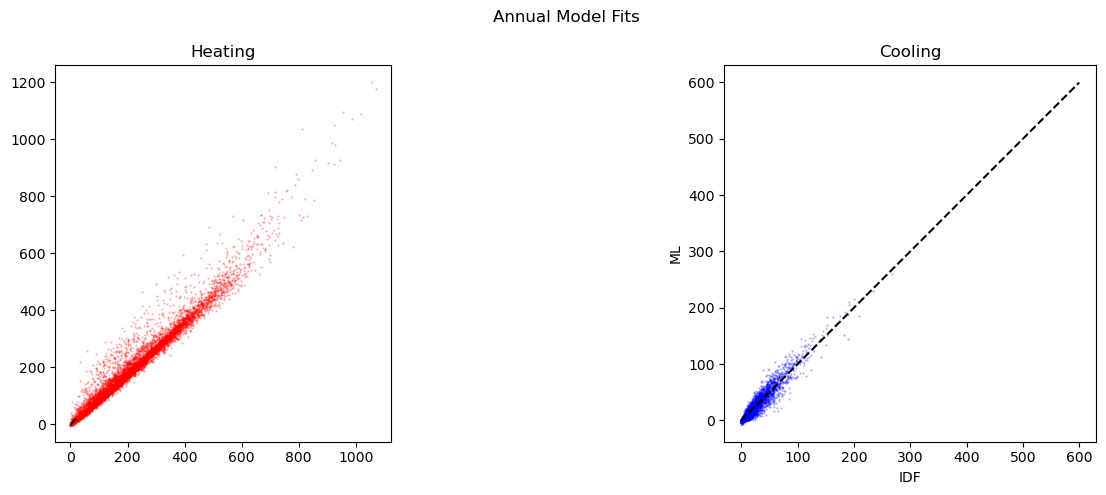

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Annual Model Fits")
h_ax = ax[0]
c_ax = ax[1]
h_ax.set_title("Heating")
c_ax.set_title("Cooling")

h_ax.scatter(
    true_results["Heating:DistrictHeating"].sum(axis=1),
    ml_annual.Heating,
    color="red",
    alpha=0.3,
    s=0.3,
)
# h_ax.set_ylim(0, 50)
# h_ax.set_xlim(0, 50)

c_ax.scatter(
    true_results["Cooling:DistrictCooling"].sum(axis=1),
    ml_annual.Cooling,
    color="blue",
    alpha=0.3,
    s=0.3,
)
c_ax.set_ylabel("ML")
c_ax.set_xlabel("IDF")
# c_ax.set_ylim(0, 50)
# c_ax.set_xlim(0, 50)
c_ax.set_aspect("equal", "box")
h_ax.set_aspect("equal", "box")
h_ax.plot([0, 20], [0, 20], color="black", linestyle="--")
c_ax.plot(
    [0, 600],
    [0, 600],
    color="black",
    linestyle="--",
)
fig.tight_layout()

In [43]:
ml_annual_e = ml_annual * building_features.loc[ml_annual.index, "gfa"].values.reshape(
    -1, 1
)

true_results_e = true_results * building_features.loc[
    true_results_ids, "gfa"
].values.reshape(-1, 1)

# ml_annual_e.sum(axis=0), true_results_e.sum(axis=0)
annual_m = ml_annual_e.sum(axis=0)
annual_t = true_results_e.sum(level=0, axis=1).sum(axis=0)

In [44]:
# with elec, but no cops
building_cvrmse = np.sqrt(
    (
        np.mean(
            ((ml_annual.sum(axis=1) + pred_elec.sum(axis=1)) - true_results.sum(axis=1))
            ** 2
        )
    )
) / np.mean(true_results.sum(axis=1))
building_cvrmse

0.10724754912325304

In [45]:
Heating_m = annual_m.Heating / 0.95
Cooling_m = annual_m.Cooling / 2.4
Elec_m = (
    (pred_elec * building_features.loc[pred_elec.index, "gfa"].values.reshape(-1, 1))
    .sum()
    .sum()
)

Heating_t = annual_t["Heating:DistrictHeating"] / 0.95
Cooling_t = annual_t["Cooling:DistrictCooling"] / 2.4
Elec_t = annual_t["Electricity:Facility"].sum()

In [46]:
((Heating_m + Cooling_m + Elec_m) - (Heating_t + Cooling_t + Elec_t)) / (
    Heating_t + Cooling_t + Elec_t
)

-0.05378129407320633

In [47]:
((Heating_m + Cooling_m) - (Heating_t + Cooling_t)) / (Heating_t + Cooling_t)

-0.07926650743267849

(array([7.196e+03, 1.154e+03, 5.920e+02, 3.470e+02, 2.160e+02, 1.700e+02,
        9.600e+01, 7.800e+01, 5.400e+01, 2.500e+01, 2.700e+01, 1.400e+01,
        8.000e+00, 9.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 2.000e+00,
        1.000e+00, 3.000e+00]),
 array([2.87596198e-06, 2.50524298e+00, 5.01048309e+00, 7.51572320e+00,
        1.00209633e+01, 1.25262034e+01, 1.50314435e+01, 1.75366836e+01,
        2.00419237e+01, 2.25471638e+01, 2.50524040e+01, 2.75576441e+01,
        3.00628842e+01, 3.25681243e+01, 3.50733644e+01, 3.75786045e+01,
        4.00838446e+01, 4.25890847e+01, 4.50943248e+01, 4.75995649e+01,
        5.01048050e+01]),
 <BarContainer object of 20 artists>)

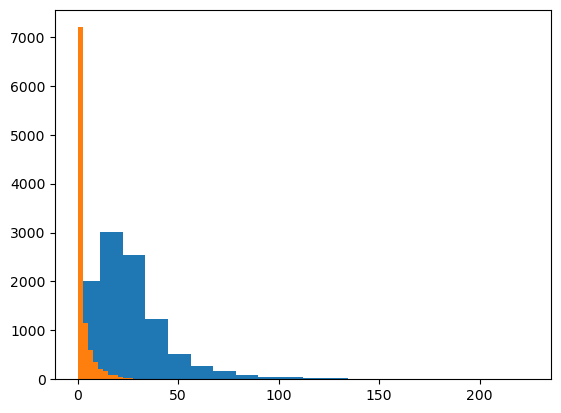

In [48]:
plt.hist(np.sqrt(residuals["Heating"]["annual"].flatten() ** 2), bins=20)
plt.hist(np.sqrt(residuals["Cooling"]["annual"].flatten() ** 2), bins=20)